# Open TA: Auto-correlations
- Brownian particle's Langevin equation: $dV = -\gamma V dt + \sqrt{2D} dW$.
    - $\gamma$ - Damping rate;
    - $D$ - Velocity diffusion constant.

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid
from scipy.signal import unit_impulse
plt.style.use('fast')

## Question a):
In this question, I choose the values of the parameters arbitrarily, since we aren't provided any concrete values. However, I do so in such a way that it is apparent how the solution decays exponentially (from $v_0 = 7.5$), initially, later arriving at a stationary state around $v = 0$ (Where the fluctuations are also clearly visible). Additionally, $dt$ is simply chosen in a way that gives us sufficient resolution of the process. Note: $dt$ had to be sufficiently small to be able to reliably resolve the cross(auto)-correlation plots, presented below, especially for the Dirac delta case.

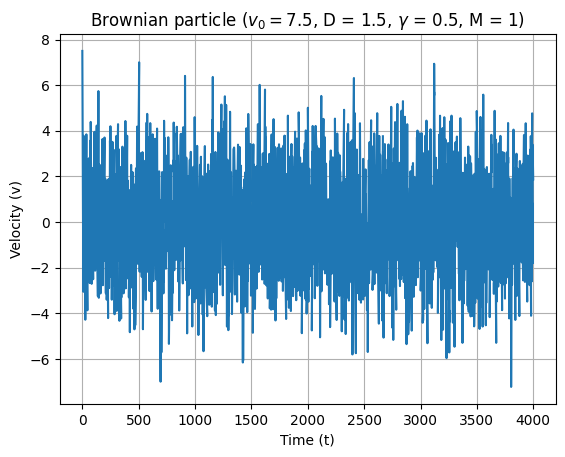

In [51]:
v0     = 7.5    # Initial position
T      = 4_000
tSteps = 20_000 # Number of time-steps
dt     = T/tSteps
gamma  = 0.5
D      = 1.5

Trajs  = []
M      = 1      # Number of trajectories
xi     = []     # White noise vector

for m in range(M):
    vVec   = [v0]                                                 # '+ 1': Just so the dimensions match...
    dW     = np.random.normal(0., np.sqrt(dt), size = tSteps + 1) # Wiener process: Mean = 0; Std_Dev = Sqrt(Var) = Sqrt(dt).
    xi.append(dW/dt)
    for i in range(tSteps):
        vVec.append(vVec[i] - gamma * vVec[i] * dt + np.sqrt(2*D) * dW[i])
    Trajs.append(vVec)
    del vVec

for i in range(M):
    plt.plot(np.linspace(0., T, tSteps + 1), Trajs[i]) # Have to add +1,
                                                       # due to the initial condition being included from the beginning.
plt.xlabel("Time (t)")
plt.ylabel("Velocity (v)")
plt.title(rf"Brownian particle ($v_0 = {v0}$, D = {D}, $\gamma$ = {gamma}, M = {M})")
plt.grid(True)
plt.show()

## Questions b) and c):
In this question, we attempt to extract the auto-correlation functions from the generated data. To do this, we compute the time-averages:

1. $C_{v\xi}(\tau) = \frac{1}{T}\int_{-T/2}^{T/2}dt v(t)\xi(t+\tau)$;

2. $C_{\xi\xi}(\tau) = \frac{1}{T}\int_{-T/2}^{T/2}dt \xi(t)\xi(t+\tau)$;

3. $C_{vv}(\tau) = \frac{1}{T}\int_{-T/2}^{T/2}dt v(t)v(t+\tau)$;

In order to do this, I shall simply compute these integrals numerically, e.g., using the trapezoidal rule.

Note that in the following I only use a **single** long trajectory!
Additionally, note that these time-averages can be replaced with ensemble averages when:
$\lim_{T\to \infty}\overline{X(t)}^{T} = \left\langle X\right\rangle$ is True, **and** the same is verified for all other moments. In this case, the process is called **ergodic**.

### 1). Cross-correlation between $v$ and $\xi$: $C_{v\xi}(\tau)$

Guaranteed to be stabilized after t[501] = 100.2.


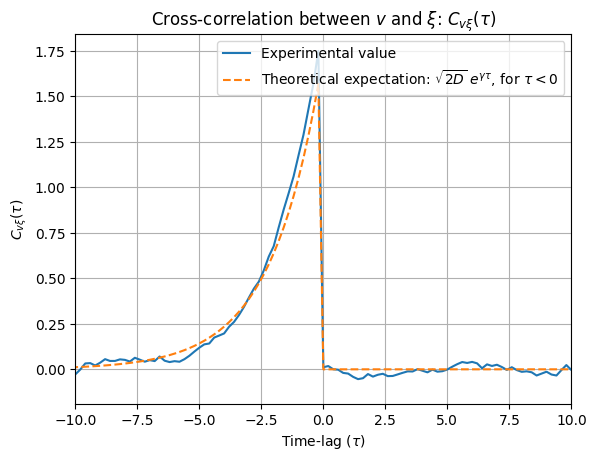

In [52]:
# Looking for stabilized part of the signal
s_i = np.argwhere(np.array([i*dt for i in range(tSteps)]) > 100.)[0, 0]
print(f'Guaranteed to be stabilized after t[{s_i}] = {[i*dt for i in range(tSteps)][s_i]}.')
T  = len(Trajs[0][s_i:-s_i]) * dt

C_vXi = np.array([1/T * trapezoid(np.array(Trajs[0][s_i:-s_i]) * xi[0][s_i+i:-s_i+i], dx = dt) for i in range(-s_i, s_i)])
# C_vXi /= max(C_vXi)

t = np.array([i*dt for i in range(-s_i, s_i)])
plt.plot(t, C_vXi, label = 'Experimental value')
plt.plot(t, np.concatenate((np.sqrt(2*D) * np.exp(gamma*t)[:s_i], 0*t[s_i:])),
         label = r'Theoretical expectation: $\sqrt{2D}$ $e^{\gamma\tau}$, for $\tau < 0$', linestyle = 'dashed')
plt.title(r'Cross-correlation between $v$ and $\xi$: $C_{v\xi}(\tau)$')
plt.xlabel(r'Time-lag ($\tau$)')
plt.ylabel(r'$C_{v\xi}(\tau)$')
plt.xlim(-10, 10)
plt.legend()
plt.grid(True)
plt.show()
# If I normalize everything, it's perfectly fine.

### 2). Auto-correlation for $\xi$: $C_{\xi\xi}(\tau)$

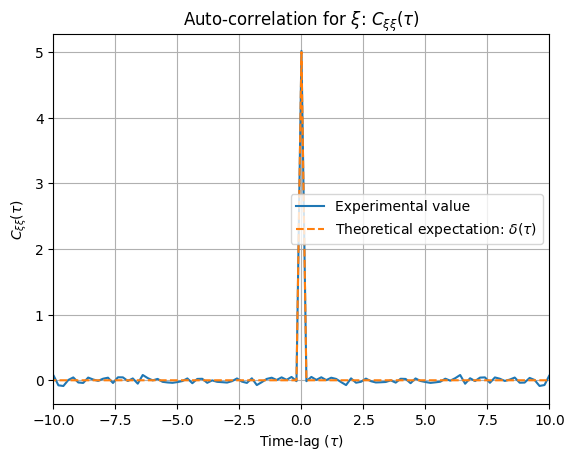

In [53]:
C_XiXi = np.array([1/T * trapezoid(np.array(xi[0][s_i:-s_i]) * xi[0][s_i+i:-s_i+i], dx = dt) for i in range(-s_i, s_i)])
# C_XiXi /= max(C_XiXi)

t = np.array([i*dt for i in range(-s_i, s_i)])
plt.plot(t, C_XiXi, label = 'Experimental value')
plt.plot(t, 5 * unit_impulse(len(t), s_i), label = r'Theoretical expectation: $\delta(\tau)$', linestyle = 'dashed')
plt.title(r'Auto-correlation for $\xi$: $C_{\xi\xi}(\tau)$')
plt.xlabel(r'Time-lag ($\tau$)')
plt.ylabel(r'$C_{\xi\xi}(\tau)$')
plt.xlim(-10, 10)
plt.legend()
plt.grid(True)
plt.show()
# If I normalize everything, it's perfectly fine.

### 3). Auto-correlation for $v$: $C_{vv}(\tau)$

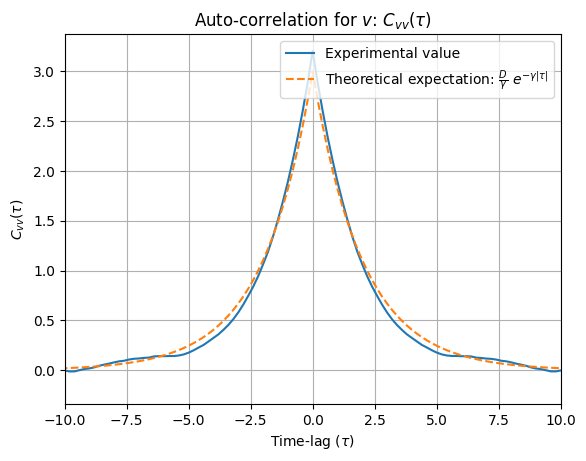

In [54]:
C_vv = np.array([1/T * trapezoid(np.array(Trajs[0][s_i:-s_i]) * Trajs[0][s_i+i:-s_i+i], dx = dt) for i in range(-s_i, s_i)])
# C_vv /= max(C_vv)

t = np.array([i*dt for i in range(-s_i, s_i)])
plt.plot(t, C_vv, label = 'Experimental value')
plt.plot(t, D/gamma * np.exp(-gamma * abs(t)), label = r'Theoretical expectation: $\frac{D}{\gamma}$ $e^{-\gamma |\tau|}$', linestyle = 'dashed')
plt.title(r'Auto-correlation for $v$: $C_{vv}(\tau)$')
plt.xlabel(r'Time-lag ($\tau$)')
plt.ylabel(r'$C_{vv}(\tau)$')
plt.xlim(-10, 10)
plt.legend()
plt.grid(True)
plt.show()
# If I normalize everything, it's perfectly fine.

Finally, verifying the fluctuation-dissipation theorem (integral form):

In [55]:
print(f'Experimental D_x = {trapezoid(C_vv[len(C_vv)//2:], dx = dt)}.')
print(f'Experimental, based on theoretical expression: D_x = {trapezoid(D/gamma * np.exp(-gamma * abs(t))[len(C_vv)//2:], dx  = dt)}.')
print(f'Theoretical value: D_x = {D/gamma**2}.')

Experimental D_x = 5.412771600397436.
Experimental, based on theoretical expression: D_x = 6.00499916686503.
Theoretical value: D_x = 6.0.


We seem to have obtained reasonably good agreement with what was expected theoretically, for all three cases!

Notes: I saw that the cross(auto)-correlation can be defined differently for discrete objects, namely with a sum, i.e., not necessarily involving complex numerical integration techniques (Although $\verb|trapezoid|$ isn't that complex...). Either way, the results seem good enough.